##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [29]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Universal Sentence Encoder-Lite demo


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder_lite"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder_lite.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder_lite.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/semantic_similarity_with_tf_hub_universal_encoder_lite.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/universal-sentence-encoder-lite/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This Colab illustrates how to use the Universal Sentence Encoder-Lite for sentence similarity task. This module is very similar to [Universal Sentence Encoder](https://www.tensorflow.org/hub/modules/google/universal-sentence-encoder/2) with the only difference that you need to run [SentencePiece](https://github.com/google/sentencepiece) processing on your input sentences.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.

# Getting started

## Setup

In [30]:
# Install seaborn for pretty visualizations
!pip3 install --quiet seaborn
# Install SentencePiece package
# SentencePiece package is needed for Universal Sentence Encoder Lite. We'll
# use it for all the text processing and sentence feature ID lookup.
!pip3 install --quiet sentencepiece

In [31]:
from absl import logging

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub
import sentencepiece as spm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

## Load the module from TF-Hub

In [32]:
module = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-lite/2")

In [33]:
input_placeholder = tf.sparse_placeholder(tf.int64, shape=[None, None])
encodings = module(
    inputs=dict(
        values=input_placeholder.values,
        indices=input_placeholder.indices,
        dense_shape=input_placeholder.dense_shape))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Load SentencePiece model from the TF-Hub Module
The SentencePiece model is conveniently stored inside the module's assets. It has to be loaded in order to initialize the processor.

In [34]:
with tf.Session() as sess:
  spm_path = sess.run(module(signature="spm_path"))

sp = spm.SentencePieceProcessor()
with tf.io.gfile.GFile(spm_path, mode="rb") as f:
  sp.LoadFromSerializedProto(f.read())
print("SentencePiece model loaded at {}.".format(spm_path))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


SentencePiece model loaded at b'/var/folders/_j/z7zdrth14_s3bcxmp4glxrw40000gp/T/tfhub_modules/539544f0a997d91c327c23285ea00c37588d92cc/assets/universal_encoder_8k_spm.model'.


In [35]:
def process_to_IDs_in_sparse_format(sp, sentences):
  # An utility method that processes sentences with the sentence piece processor
  # 'sp' and returns the results in tf.SparseTensor-similar format:
  # (values, indices, dense_shape)
  ids = [sp.EncodeAsIds(x) for x in sentences]
  max_len = max(len(x) for x in ids)
  dense_shape=(len(ids), max_len)
  values=[item for sublist in ids for item in sublist]
  indices=[[row,col] for row in range(len(ids)) for col in range(len(ids[row]))]
  return (values, indices, dense_shape)

### Test the module with a few examples

In [36]:
# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

values, indices, dense_shape = process_to_IDs_in_sparse_format(sp, messages)

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.053387485444545746, 0.053194381296634674, -0.05235603079199791, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.03533291444182396, -0.047149717807769775, 0.012305542826652527, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.004081586841493845, -0.08954867720603943, 0.03737198933959007, ...]



# Semantic Textual Similarity (STS) task example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [37]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session, input_placeholder, messages):
  values, indices, dense_shape = process_to_IDs_in_sparse_format(sp,messages)

  message_embeddings = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})
  
  plot_similarity(messages, message_embeddings, 90)

## Similarity visualized
Here we show the similarity in a heat map. The final graph is a 9x9 matrix where each entry `[i, j]` is colored based on the inner product of the encodings for sentence `i` and `j`.

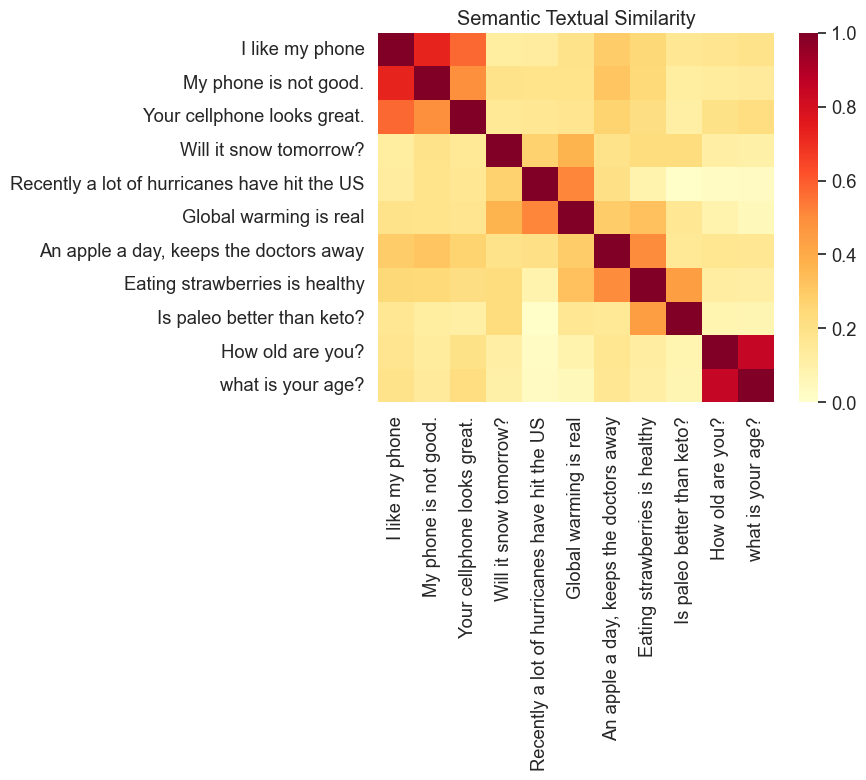

In [38]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]


with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, input_placeholder, messages)

## Evaluation: STS (Semantic Textual Similarity) Benchmark

The [**STS Benchmark**](https://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) provides an intristic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is then used to evaluate the quality of the machine similarity scores against human judgements.

### Download data

In [39]:
import pandas
import scipy
import math


def load_sts_dataset(filename):
  # Loads a subset of the STS dataset into a DataFrame. In particular both
  # sentences and their human rated similarity score.
  sent_pairs = []
  with tf.gfile.GFile(filename, "r") as f:
    for line in f:
      ts = line.strip().split("\t")
      # (sent_1, sent_2, similarity_score)
      sent_pairs.append((ts[5], ts[6], float(ts[4])))
  return pandas.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
  sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

  sts_dev = load_sts_dataset(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
  sts_test = load_sts_dataset(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

  return sts_dev, sts_test


sts_dev, sts_test = download_and_load_sts_data()

### Build evaluation graph

In [40]:
sts_input1 = tf.sparse_placeholder(tf.int64, shape=(None, None))
sts_input2 = tf.sparse_placeholder(tf.int64, shape=(None, None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(
    module(
        inputs=dict(values=sts_input1.values,
                    indices=sts_input1.indices,
                    dense_shape=sts_input1.dense_shape)),
    axis=1)
sts_encode2 = tf.nn.l2_normalize(
    module(
        inputs=dict(values=sts_input2.values,
                    indices=sts_input2.indices,
                    dense_shape=sts_input2.dense_shape)),
    axis=1)

sim_scores = -tf.acos(tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1))


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Evaluate sentence embeddings

In [41]:
#@title Choose dataset for benchmark
dataset = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

values1, indices1, dense_shape1 = process_to_IDs_in_sparse_format(sp, dataset['sent_1'].tolist())
values2, indices2, dense_shape2 = process_to_IDs_in_sparse_format(sp, dataset['sent_2'].tolist())
similarity_scores = dataset['sim'].tolist()

In [42]:
def run_sts_benchmark(session):
  """Returns the similarity scores"""
  scores = session.run(
      sim_scores,
      feed_dict={
          sts_input1.values: values1,
          sts_input1.indices:  indices1,
          sts_input1.dense_shape:  dense_shape1,
          sts_input2.values:  values2,
          sts_input2.indices:  indices2,
          sts_input2.dense_shape:  dense_shape2,
      })
  return scores


with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, similarity_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.7856485131697498
p-value = 1.065710265e-314
